R²: 0.3111906723689658
RMSE: 21.431689285184582
Coefficients: [ 2.23445755e-01  1.94861568e+00 -6.65957779e-02  3.78780779e-01
  1.40452541e-03  2.25557048e-01]


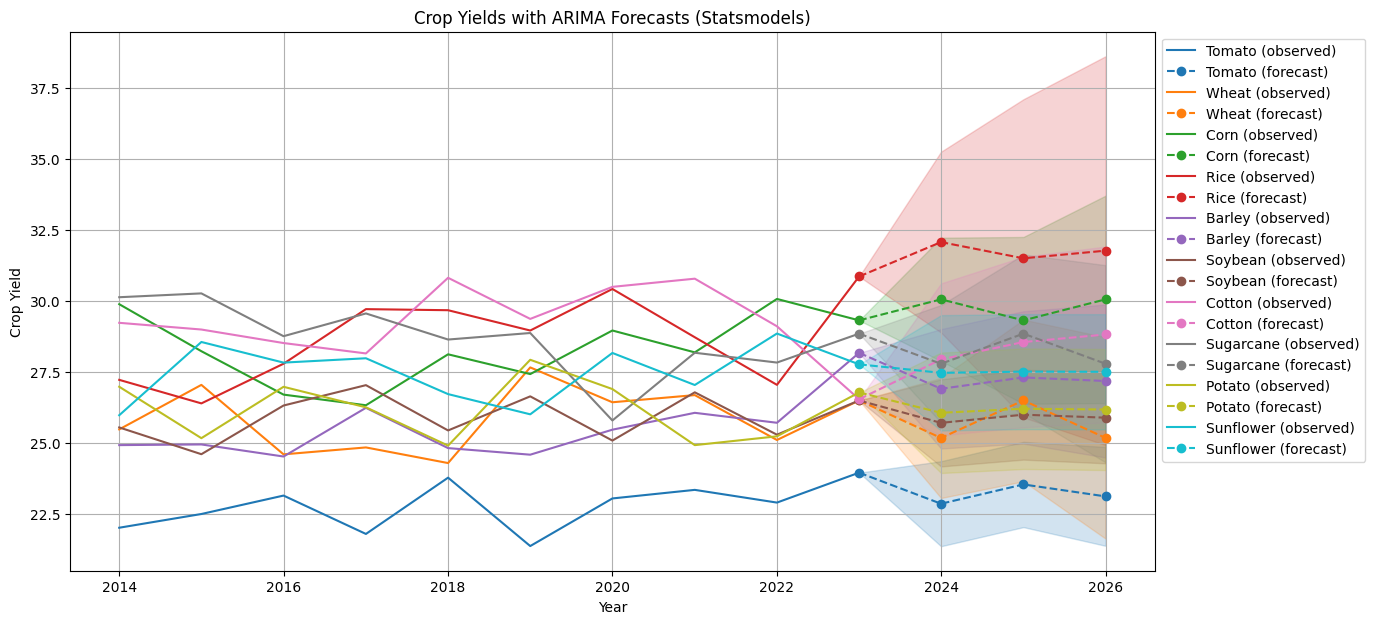

                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -13.936
Date:                Tue, 16 Sep 2025   AIC                             33.872
Time:                        22:05:53   BIC                             34.464
Sample:                    01-01-2014   HQIC                            32.596
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1429      0.702     -0.204      0.839      -1.519       1.233
ma.L1         -0.9985    233.511     -0.004      0.997    -458.671     456.674
sigma2         0.9757    227.272      0.004      0.9

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month

crops = ["Tomato", "Wheat", "Corn", "Rice", "Barley", "Soybean", "Cotton", "Sugarcane", "Potato", "Sunflower"]

palette = sns.color_palette("tab10", n_colors=len(crops))

# -------------------
# Linear Regression
# -------------------

# Select features (from your EDA results)
X = ds[["Soil_Quality", "Humidity", "N", "P", "K", "Soil_pH"]]
y = ds["Crop_Yield"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficients:", model.coef_)

# -------------------
# ARIMA
# -------------------

# Filter dataset for tomato yields by year
# tomato = ds[ds["Crop_Type"] == "Tomato"].groupby("Year")["Crop_Yield"].mean()


# Fit ARIMA (p,d,q = simple example)
# Model = ARIMA(tomato, order=(1,1,1))  # AR=1, I=1, MA=1
# results = model.fit()
# AR (p) = auto-regression - depends on past values (like yield in 2022).
# I (d) = differencing - helps remove trends (e.g., steady growth each year).
# MA (q) = moving average - depends on past forecast errors.
# Look back 1 lag in yields,
# Difference once to remove trend,
# Use 1 lag of errors

# Forecast with confidence intervals
# forecast = results.get_forecast(steps=3)
# mean_forecast = forecast.predicted_mean
# conf_int = forecast.conf_int()

plt.figure(figsize=(14, 7))

for i, crop in enumerate(crops):
    series = ds[ds["Crop_Type"] == crop].groupby("Year")["Crop_Yield"].mean()
    series.index = pd.to_datetime(series.index.astype(str))
    color = palette[i]

    # Observed
    plt.plot(series.index, series.values, label=f"{crop} (observed)", color=color)

    try:
        model = ARIMA(series, order=(1,1,1))
        results = model.fit()

        forecast_res = results.get_forecast(steps=3)
        mean_forecast = forecast_res.predicted_mean
        conf_int = forecast_res.conf_int()

        future_index = pd.date_range(start=series.index[-1] + pd.offsets.YearEnd(0), 
                                     periods=3, freq="YE")
        
        forecast_index = [series.index[-1]] + list(future_index)
        forecast_values = [series.values[-1]] + list(mean_forecast)

        lower_ci = [series.values[-1]] + list(conf_int.iloc[:, 0])
        upper_ci = [series.values[-1]] + list(conf_int.iloc[:, 1])

        # Forecast + interval
        plt.plot(forecast_index, forecast_values, linestyle="--", marker="o", color=color, label=f"{crop} (forecast)")
        plt.fill_between(forecast_index,
                         lower_ci,
                         upper_ci,
                         color=color, alpha=0.2)

    except Exception as e:
        print(f"ARIMA failed for {crop}: {e}")



plt.title("Crop Yields with ARIMA Forecasts (Statsmodels)")
plt.xlabel("Year")
plt.ylabel("Crop Yield")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

print(results.summary())

